In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [16]:
# CELL 2: Helper functions (load + show)
def load_image(path, size=(512, 512)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at path: {path}")
    img = cv2.resize(img, size)
    return img

def show_images(images, titles, figsize=(14, 4)):
    plt.figure(figsize=figsize)
    for i, (im, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(1, len(images), i)
        plt.imshow(im, cmap="gray")
        plt.title(title)
        plt.axis("off")
    plt.show()

In [17]:
# CELL 3: Noise models (for testing)
def add_gaussian_noise(img, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, img.shape)
    noisy = img.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(img, prob=0.02):
    noisy = img.copy()
    rnd = np.random.rand(*img.shape)
    noisy[rnd < prob] = 0
    noisy[rnd > 1 - prob] = 255
    return noisy

def add_speckle_noise(img):
    noise = np.random.randn(*img.shape)
    noisy = img.astype(np.float32) + img.astype(np.float32) * noise
    return np.clip(noisy, 0, 255).astype(np.uint8)


In [18]:
# CELL 4: Your filters (Mean + Gaussian)
def mean_filter(img, ksize=5):
    if ksize % 2 == 0:
        raise ValueError("ksize must be odd (e.g., 3, 5, 7).")
    return cv2.blur(img, (ksize, ksize))

def gaussian_filter(img, ksize=5, sigma=0):
    if ksize % 2 == 0:
        raise ValueError("ksize must be odd (e.g., 3, 5, 7).")
    if sigma < 0:
        raise ValueError("sigma must be >= 0.")
    return cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)


In [19]:
# CELL 5: Metrics (MSE + PSNR)
def mse(original, processed):
    original = original.astype(np.float32)
    processed = processed.astype(np.float32)
    return np.mean((original - processed) ** 2)

def psnr(original, processed):
    m = mse(original, processed)
    if m == 0:
        return 100.0
    return 10 * math.log10((255.0 ** 2) / m)


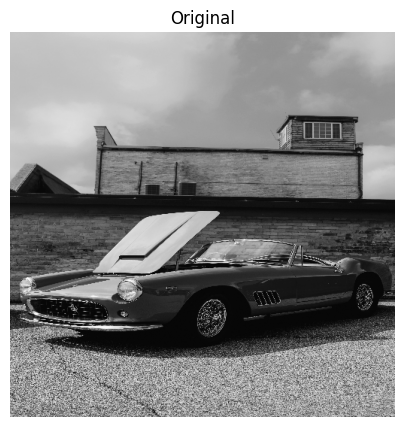

In [20]:
# CELL 6: Load an image (change the path)
# Put an image in the same folder as the notebook OR use a full path
img_path = "ferrari.jpg"  # change this
original = load_image(img_path)

show_images([original], ["Original"], figsize=(5, 5))


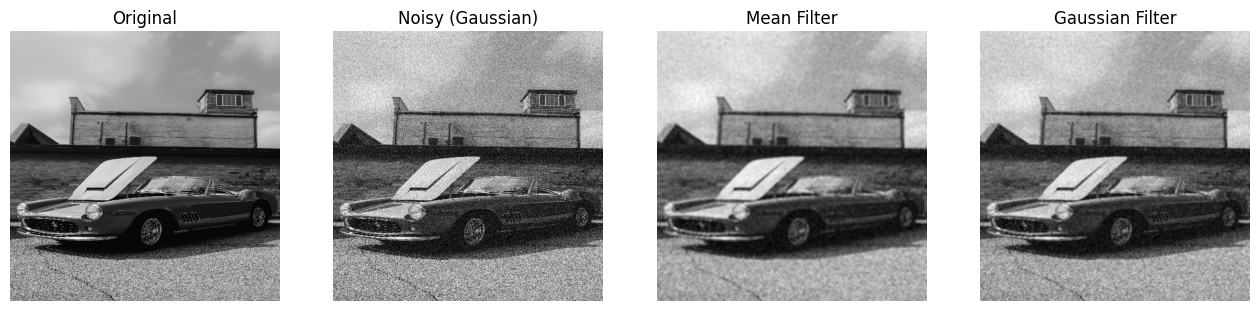

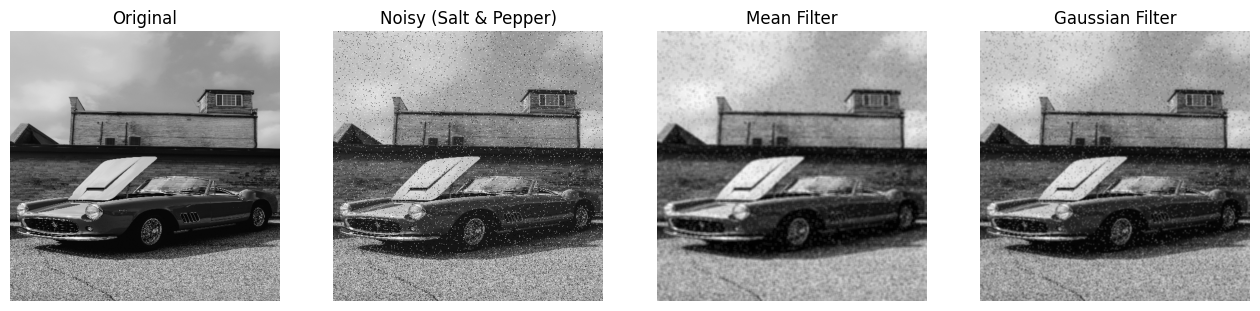

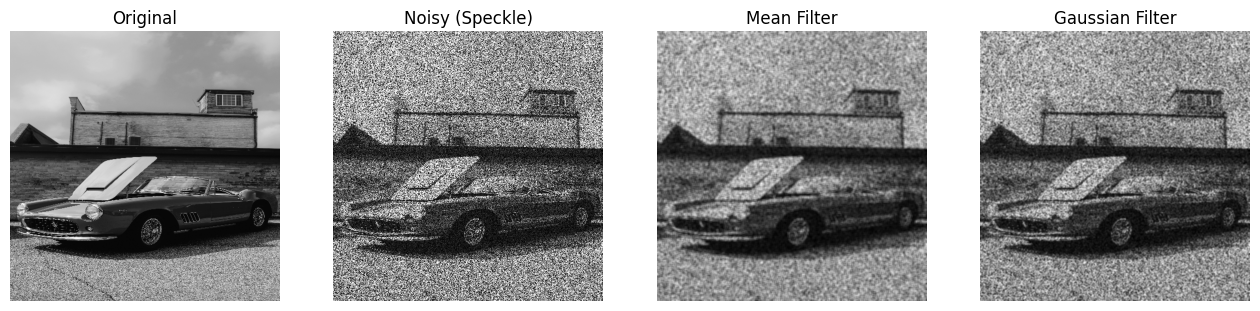

In [21]:
# CELL 7: Run experiment for one image (all noises, mean vs gaussian)
kernel_size = 5  # keep consistent across the whole project

noise_funcs = {
    "Gaussian": lambda im: add_gaussian_noise(im, sigma=25),
    "Salt & Pepper": lambda im: add_salt_pepper_noise(im, prob=0.02),
    "Speckle": lambda im: add_speckle_noise(im),
}

results = []

for noise_name, nfunc in noise_funcs.items():
    noisy = nfunc(original)

    den_mean = mean_filter(noisy, ksize=kernel_size)
    den_gauss = gaussian_filter(noisy, ksize=kernel_size, sigma=0)

    results.append([noise_name, "Mean", mse(original, den_mean), psnr(original, den_mean)])
    results.append([noise_name, "Gaussian", mse(original, den_gauss), psnr(original, den_gauss)])

    show_images(
        [original, noisy, den_mean, den_gauss],
        ["Original", f"Noisy ({noise_name})", "Mean Filter", "Gaussian Filter"],
        figsize=(16, 4)
    )


In [22]:
# CELL 8: Results table (nice for marks)
df = pd.DataFrame(results, columns=["Noise Type", "Filter", "MSE", "PSNR"])
df


,Noise Type,Filter,MSE,PSNR
0,Gaussian,Mean,526.219910,20.919131
1,Gaussian,Gaussian,411.771606,21.984240
2,Salt & Pepper,Mean,543.234131,20.780933
3,Salt & Pepper,Gaussian,438.244659,21.713637
4,Speckle,Mean,1239.684937,17.197690
5,Speckle,Gaussian,1372.341064,16.756183


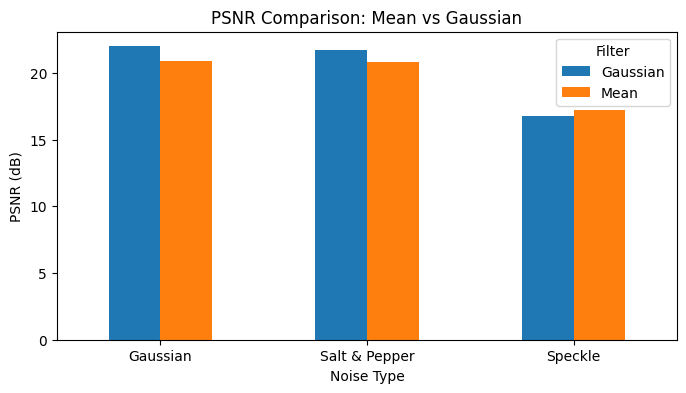

In [23]:
# CELL 9: PSNR bar chart comparison
pivot = df.pivot(index="Noise Type", columns="Filter", values="PSNR")
pivot.plot(kind="bar", figsize=(8, 4))
plt.title("PSNR Comparison: Mean vs Gaussian")
plt.ylabel("PSNR (dB)")
plt.xticks(rotation=0)
plt.show()
